In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, "../..")

from hydra import compose, initialize

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")

import torch
import pytorch_lightning as L

from helpers.dataset import get_dataloaders

In [3]:
cfgs_path = "../../configs"
with initialize(config_path=cfgs_path, version_base="1.1"):
    cfg = compose(config_name="train.yaml", overrides=["model=baseline", "username=cizinsky", "data.batch_size=32"])

In [4]:
L.seed_everything(cfg.seed);

Seed set to 42


### Some initial exploration of data

In [5]:
trn_dataloader, val_dataloader = get_dataloaders(cfg)

In [6]:
batch = next(iter(trn_dataloader))

In [7]:
x, y = batch
bsz = x.shape[0]
n_trn_steps_per_epoch = len(trn_dataloader)
n_val_steps_per_epoch = len(val_dataloader)

print(f"Training steps per epoch: {n_trn_steps_per_epoch}, batch size: {bsz}, so in total {n_trn_steps_per_epoch * bsz} samples")
print(f"Validation steps per epoch: {n_val_steps_per_epoch}, batch size: {bsz}, so in total {n_val_steps_per_epoch * bsz} samples")
print(f"Shape of the input: {x.shape} and expected output: {y.shape}")


Training steps per epoch: 366, batch size: 32, so in total 11712 samples
Validation steps per epoch: 41, batch size: 32, so in total 1312 samples
Shape of the input: torch.Size([32, 354, 19]) and expected output: torch.Size([32])


In [8]:
sample = x[0].detach().cpu().numpy()
df = pd.DataFrame(sample)


In [9]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,8.625779,8.819997,6.918990,8.017615,8.351605,7.182529,8.525332,6.890585,8.270564,8.020195,7.283266,8.572837,7.541444,7.746610,8.196423,5.581677,6.905996,7.483817,7.988425
1,7.348525,8.242789,7.188311,8.369450,7.673393,8.140412,8.428155,7.328053,8.429401,7.191350,8.626237,8.443142,8.909777,8.223314,8.657772,7.515231,8.377763,7.782933,6.636536
2,8.719136,8.532149,8.862695,8.047855,8.456556,7.463485,8.505449,7.334066,8.525789,8.329983,7.404820,8.164557,7.817726,7.950250,8.485247,7.890963,8.742887,7.543606,8.008504
3,7.270770,8.180936,7.710434,7.963088,7.593810,7.891791,7.346987,7.562978,7.113100,6.775773,8.440196,7.944581,8.199443,6.584760,7.585811,6.018261,7.126939,7.665241,7.609947
4,8.425985,8.331755,8.333324,8.041826,6.736005,7.800352,8.021780,7.663130,8.271653,7.564948,8.234148,7.726952,8.393344,7.246364,8.333677,7.183872,8.245544,7.661923,8.055215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,3.814275,4.320608,2.571841,4.475976,3.430514,4.565377,4.041196,4.027538,4.566713,4.140441,4.086885,4.838839,3.868309,3.726475,4.500292,3.921296,2.833544,3.189739,3.782363
350,1.662428,3.453226,3.248454,4.126576,3.668552,4.729429,4.670361,4.665745,4.978351,4.404862,4.920284,4.627915,4.528773,5.589223,4.993004,5.194325,2.508592,3.946384,4.947007
351,3.959224,4.737752,3.478806,3.323052,1.697185,4.202190,3.028826,4.107830,4.508709,4.332205,4.352567,5.176566,3.999214,5.067031,4.227925,4.273339,3.712092,3.303807,4.335062
352,3.784043,3.141272,3.757035,3.509835,4.046625,2.851934,3.323742,2.541637,4.371895,4.654503,4.717477,4.932868,2.972885,4.244107,4.279671,4.670731,4.073755,3.726034,3.731879


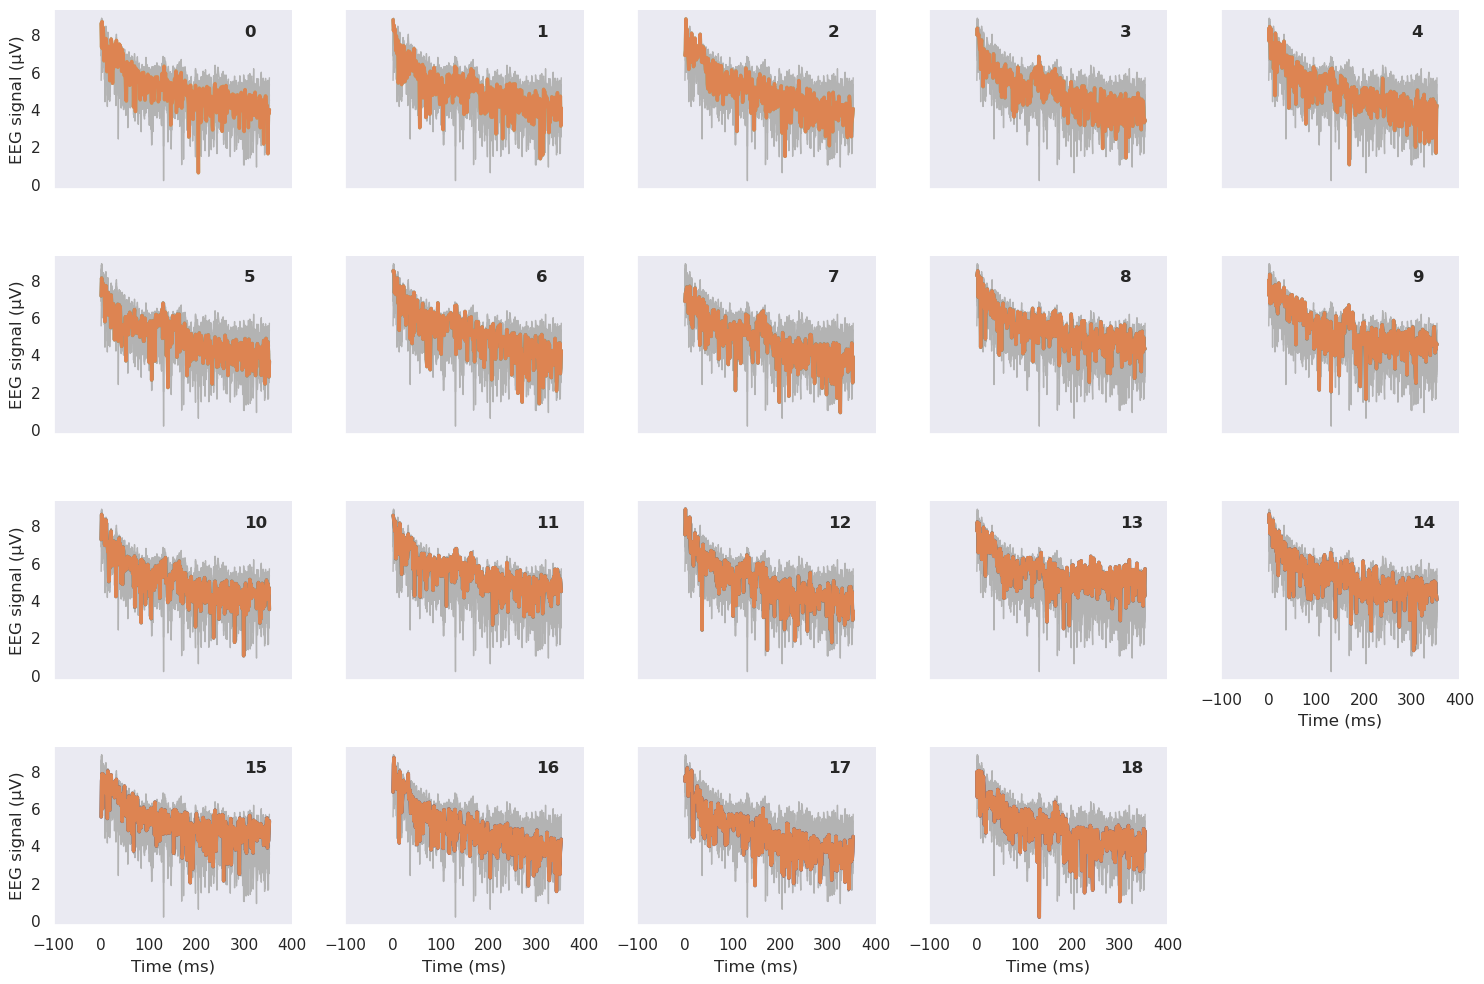

In [10]:
# 1. Reset the index into a “time” column
df = df.reset_index().rename(columns={"index": "time"})

# 2. Make sure your electrode columns are strings
df.columns = df.columns.map(str)

# 3. Melt into long form exactly as before
df_long = pd.melt(
    df,
    id_vars="time",
    value_vars=[str(i) for i in range(19)],
    var_name="electrode",
    value_name="signal",
)

# 3) Set up the dark theme, and make the facet grid
sns.set_theme(style="dark")

g = sns.relplot(
    data=df_long,
    x="time", y="signal",
    col="electrode",      # one facet per electrode
    kind="line",
    palette="crest",      # color palette for the highlighted line
    hue="electrode",      # gives each electrode its own color
    col_wrap=5,           # wrap into 5 columns → 4 rows (since 19 electrodes)
    height=2.5,           # tweak to taste
    aspect=1.2,
    legend=False,
    linewidth=2.5,
    zorder=5,
)

# 4) Loop over each facet, add annotation, and draw the “background” of all electrodes
for elec, ax in g.axes_dict.items():
    # Draw all electrodes in the background
    sns.lineplot(
        data=df_long,
        x="time", y="signal",
        units="electrode",         # treat each electrode as a separate series
        estimator=None,            # no aggregation
        color=".7",                # light gray background
        linewidth=1,
        ax=ax,
    )

    # Re-draw the highlighted electrode on top
    subset = df_long[df_long["electrode"] == elec]
    sns.lineplot(
        data=subset,
        x="time", y="signal",
        ax=ax,
        linewidth=2.5,
        zorder=10,
    )

    # Place the electrode number inside the plot
    ax.text(
        0.8, 0.85, elec,
        transform=ax.transAxes,
        fontweight="bold"
    )

    # Optional: reduce tick density
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::int(len(xticks)/6) or 1])  # e.g. six ticks max

# 5) Tidy up
g.set_titles("")               # we already annotated manually
g.set_axis_labels("Time (ms)", "EEG signal (µV)")
plt.tight_layout()
plt.show()

In [11]:
from transformers import PatchTSTConfig, PatchTSTForClassification

In [12]:
config = PatchTSTConfig(
    num_input_channels=19,
    num_targets=1,
    context_length=354,
    patch_length=12,
    stride=12,
    use_cls_token=True,
)
model = PatchTSTForClassification(config=config).to("cuda").to(torch.float64)

In [13]:
type(model)

transformers.models.patchtst.modeling_patchtst.PatchTSTForClassification

In [14]:
# total and trainable parameter counts
total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters:     {total_params:,} ({total_params/1e6:.2f}M)")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)")


Total parameters:     643,073 (0.64M)
Trainable parameters: 599,041 (0.60M)


In [15]:
outputs = model(past_values=x.to("cuda"))
labels = outputs.prediction_logits

In [16]:
labels.shape

torch.Size([32, 1])